### [Backtesting News Sentiment with Asset Prices](https://levelup.gitconnected.com/backtesting-news-sentiment-with-asset-prices-with-full-code-ffb1008ccc51)

Fundamentals, human psychology, and emotion drive the financial markets. News sentiment analysis quantifies these emotional factors by analysing the language, tone, and context of news articles and headlines. This approach is grounded in behavioural finance theory, which recognises that markets are not perfectly efficient due to cognitive biases and the emotional reactions of market participants.

#### The Theoretical Framework - Key Theories

1. **Information Asymmetry**: Not all market participants receive or process information simultaneously. Those who can quickly analyse news sentiment may gain a temporary advantage.

2. **Investor Attention Theory**: Assets that receive more media attention experience higher trading volumes and potentially more significant price movements, regardless of whether the news is positive or negative.

3. **Prospect Theory**: Developed by Kahneman and Tversky, this theory suggests investors react more strongly to negative news than positive news, creating asymmetric market responses.

4. **Sentiment Lag Effect**: Markets may not immediately reflect the full impact of news, creating a lag between sentiment shifts and price movements that can be exploited.

#### Quantifying Sentiment

Sentiment analysis transforms qualitative news content into quantitative data through several methods:

1. **Dictionary-Based Approaches**: Using predefined lexicons of words labelled with sentiment values (positive/negative/neutral).

2. **Machine Learning Models**: Training algorithms to recognise sentiment patterns based on labelled examples.

3. **Natural Language Processing (NLP)**: Applying sophisticated techniques like named entity recognition, relationship extraction, and contextual understanding.

4. **Fine-tuned Language Models**: Using domain-specific adaptations of large language models (LLMs) pre-trained on financial texts.

The resulting sentiment scores typically range from -1 (extremely negative) to +1 (extremely positive), with 0 representing neutral sentiment.

#### Expected Relationships with Asset Prices

The theoretical relationship between sentiment scores and asset prices follows several patterns:

1. **Direct Correlation**: Positive sentiment → Price increases; Negative sentiment → Price decreases

2. **Magnitude Effect**: Stronger sentiment (either positive or negative) should correlate with more significant price movements

3. **Temporal Effects**: Immediate impact (minutes to hours), Short-term implications (1–3 days), Mean reversion (price correction after overreaction)

4. **Industry-Specific Sensitivities**: Some sectors (e.g., technology, consumer goods) may be more sensitive to sentiment changes than others (e.g., utilities, basic materials)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install -q numpy pandas matplotlib seaborn
!pip install -q scikit-learn xgboost
!pip install -q -U eodhd

In [3]:
import requests
import pandas as pd
import json
from datetime import datetime, timedelta
from eodhd import APIClient

def fetch_sentiments(symbols, start_date, end_date, api_token):
    """
    Fetch sentiment data from EODHD API for a given symbol and date range.
    
    Args:
        symbols (str): Symbol or comma-separated list of symbols
        start_date (str): Start date in YYYY-MM-DD format
        end_date (str): End date in YYYY-MM-DD format
        api_token (str): Your EODHD API token
    
    Returns:
        pandas.DataFrame: DataFrame containing sentiment data, sorted by date (oldest first)
    """
    base_url = "https://eodhd.com/api/sentiments"
    
    params = {
        "s": symbols,
        "from": start_date,
        "to": end_date,
        "api_token": api_token,
        "fmt": "json"
    }
    
    try:
        print(f"Fetching sentiment data for {symbols} from {start_date} to {end_date}...")
        response = requests.get(base_url, params=params)
        response.raise_for_status()  # Raise exception for HTTP errors
        
        data = response.json()
        
        # Handle different response structures
        if isinstance(data, list):
            # If response is a list of records
            df = pd.DataFrame(data)
        elif isinstance(data, dict):
            # If response is a dictionary (likely with symbol as key)
            records = []
            
            for symbol, symbol_data in data.items():
                if isinstance(symbol_data, list):
                    # List of records for this symbol
                    for record in symbol_data:
                        if 'symbol' not in record:
                            record['symbol'] = symbol
                        records.append(record)
                elif isinstance(symbol_data, dict):
                    # Dictionary of dates or metrics for this symbol
                    for date, date_data in symbol_data.items():
                        if isinstance(date_data, dict):
                            records.append({'symbol': symbol, 'date': date, **date_data})
                        else:
                            records.append({'symbol': symbol, 'date': date, 'sentiment': date_data})
            
            df = pd.DataFrame(records)
        else:
            print(f"Unexpected response format: {type(data)}")
            return pd.DataFrame()
        
        # Convert date column to datetime if it exists
        if 'date' in df.columns:
            df['date'] = pd.to_datetime(df['date'])
            # Sort by date (oldest first)
            df = df.sort_values('date')
        
        print(f"Successfully fetched sentiment data with {len(df)} records.")
        return df
        
    except requests.exceptions.RequestException as e:
        print(f"API request error: {e}")
        return pd.DataFrame()
    except json.JSONDecodeError as e:
        print(f"JSON decode error: {e}")
        print(f"Response content: {response.text[:200]}...")  # Show first 200 chars of response
        return pd.DataFrame()
    except Exception as e:
        print(f"Unexpected error: {e}")
        return pd.DataFrame()

def fetch_stock_data(symbol, start_date, end_date, api_token):
    """
    Fetch historical stock price data from EODHD API.
    
    Args:
        symbol (str): Single stock symbol
        start_date (str): Start date in YYYY-MM-DD format
        end_date (str): End date in YYYY-MM-DD format
        api_token (str): Your EODHD API token
    
    Returns:
        pandas.DataFrame: DataFrame containing historical stock data, sorted by date (oldest first)
    """
    base_url = f"https://eodhd.com/api/eod/{symbol}"
    
    params = {
        "from": start_date,
        "to": end_date,
        "api_token": api_token,
        "fmt": "json"
    }
    
    try:
        print(f"Fetching stock data for {symbol} from {start_date} to {end_date}...")
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        
        data = response.json()
        
        if isinstance(data, list):
            df = pd.DataFrame(data)
            # Add symbol column if not already present
            if 'symbol' not in df.columns:
                df['symbol'] = symbol
            
            # Convert date to datetime
            if 'date' in df.columns:
                df['date'] = pd.to_datetime(df['date'])
                # Sort by date (oldest first)
                df = df.sort_values('date')
            
            print(f"Successfully fetched stock data with {len(df)} records.")
            return df
        else:
            print(f"Unexpected response format for stock data: {type(data)}")
            return pd.DataFrame()
            
    except requests.exceptions.RequestException as e:
        print(f"API request error: {e}")
        return pd.DataFrame()
    except json.JSONDecodeError as e:
        print(f"JSON decode error: {e}")
        print(f"Response content: {response.text[:200]}...")  # Show first 200 chars of response
        return pd.DataFrame()
    except Exception as e:
        print(f"Unexpected error: {e}")
        return pd.DataFrame()

def combine_data(sentiment_df, stock_df):
    """
    Combine sentiment and stock data into a single DataFrame.
    
    Args:
        sentiment_df (pandas.DataFrame): Sentiment data
        stock_df (pandas.DataFrame): Stock price data
    
    Returns:
        pandas.DataFrame: Combined DataFrame with sentiment and stock data, sorted by date (oldest first)
    """
    if sentiment_df.empty or stock_df.empty:
        print("Cannot combine data - one or both DataFrames are empty.")
        return pd.DataFrame()
    
    # Make sure both DataFrames have the same date format
    sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
    stock_df['date'] = pd.to_datetime(stock_df['date'])
    
    # Merge on date and symbol
    combined_df = pd.merge(stock_df, sentiment_df, on=['date', 'symbol'], how='left')
    
    # Sort by date (oldest first)
    combined_df = combined_df.sort_values('date')
    
    print(f"Successfully combined data with {len(combined_df)} records.")
    return combined_df

# Calculate dates for last 365 days
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')

import os
from dotenv import load_dotenv
load_dotenv()

# API configuration
API_TOKEN = os.getenv('EODHD_API_TOKEN', default='demo') # Insert your API token here
SYMBOL = "NVDA.US"  # Using single symbol for simplicity

# Part 1: Fetch sentiment data
sentiment_df = fetch_sentiments(SYMBOL, start_date, end_date, API_TOKEN)

# Part 2: Fetch stock data
stock_df = fetch_stock_data(SYMBOL, start_date, end_date, API_TOKEN)

# Display results
print("\n---- Sentiment Data ----")
if not sentiment_df.empty:
    display(sentiment_df.tail())
    print("\nSentiment data columns explanation:")
    print("- date: The date of sentimental data aggregation")
    print("- count: The number of news articles used for data aggregation")
    print("- normalized: Sentiment score based on negative/positive mentions (-1 to 1)")
    print(f"\nDate range: {sentiment_df['date'].min()} to {sentiment_df['date'].max()}")
else:
    print("No sentiment data available.")

print("\n---- Stock Price Data ----")
if not stock_df.empty:
    display(stock_df.tail())
    print("\nStock data columns explanation:")
    print("- date: Trading date")
    print("- open: Opening price")
    print("- high: Highest price of the day")
    print("- low: Lowest price of the day")
    print("- close: Closing price")
    print("- adjusted_close: Closing price adjusted for dividends and splits")
    print("- volume: Trading volume")
    print(f"\nDate range: {stock_df['date'].min()} to {stock_df['date'].max()}")
else:
    print("No stock data available.")

# Optionally combine the data
if not sentiment_df.empty and not stock_df.empty:
    print("\n---- Combined Data ----")
    combined_df = combine_data(sentiment_df, stock_df)
    display(combined_df.tail())

Fetching sentiment data for NVDA.US from 2024-04-08 to 2025-04-08...
Successfully fetched sentiment data with 366 records.
Fetching stock data for NVDA.US from 2024-04-08 to 2025-04-08...
Successfully fetched stock data with 251 records.

---- Sentiment Data ----


,date,count,normalized,symbol
4,2025-04-04,46,0.24330000,NVDA.US
3,2025-04-05,23,0.59730000,NVDA.US
2,2025-04-06,14,0.68730000,NVDA.US
1,2025-04-07,25,0.60700000,NVDA.US
0,2025-04-08,4,0.99500000,NVDA.US



Sentiment data columns explanation:
- date: The date of sentimental data aggregation
- count: The number of news articles used for data aggregation
- normalized: Sentiment score based on negative/positive mentions (-1 to 1)

Date range: 2024-04-08 00:00:00 to 2025-04-08 00:00:00

---- Stock Price Data ----


,date,open,high,low,close,adjusted_close,volume,symbol
246,2025-04-01,108.51500000,110.20000000,106.47000000,110.15000000,110.15000000,222614000,NVDA.US
247,2025-04-02,107.29000000,111.98000000,106.79000000,110.42000000,110.42000000,220601203,NVDA.US
248,2025-04-03,103.51000000,105.63000000,101.60000000,101.80000000,101.80000000,338769406,NVDA.US
249,2025-04-04,98.91000000,100.13000000,92.11000000,94.31000000,94.31000000,532273812,NVDA.US
250,2025-04-07,87.46000000,101.75000000,86.62000000,97.64000000,97.64000000,611041347,NVDA.US



Stock data columns explanation:
- date: Trading date
- open: Opening price
- high: Highest price of the day
- low: Lowest price of the day
- close: Closing price
- adjusted_close: Closing price adjusted for dividends and splits
- volume: Trading volume

Date range: 2024-04-08 00:00:00 to 2025-04-07 00:00:00

---- Combined Data ----
Successfully combined data with 251 records.


,date,open,high,low,close,adjusted_close,volume,symbol,count,normalized
246,2025-04-01,108.51500000,110.20000000,106.47000000,110.15000000,110.15000000,222614000,NVDA.US,25,0.58540000
247,2025-04-02,107.29000000,111.98000000,106.79000000,110.42000000,110.42000000,220601203,NVDA.US,24,0.54530000
248,2025-04-03,103.51000000,105.63000000,101.60000000,101.80000000,101.80000000,338769406,NVDA.US,39,0.29040000
249,2025-04-04,98.91000000,100.13000000,92.11000000,94.31000000,94.31000000,532273812,NVDA.US,46,0.24330000
250,2025-04-07,87.46000000,101.75000000,86.62000000,97.64000000,97.64000000,611041347,NVDA.US,25,0.60700000


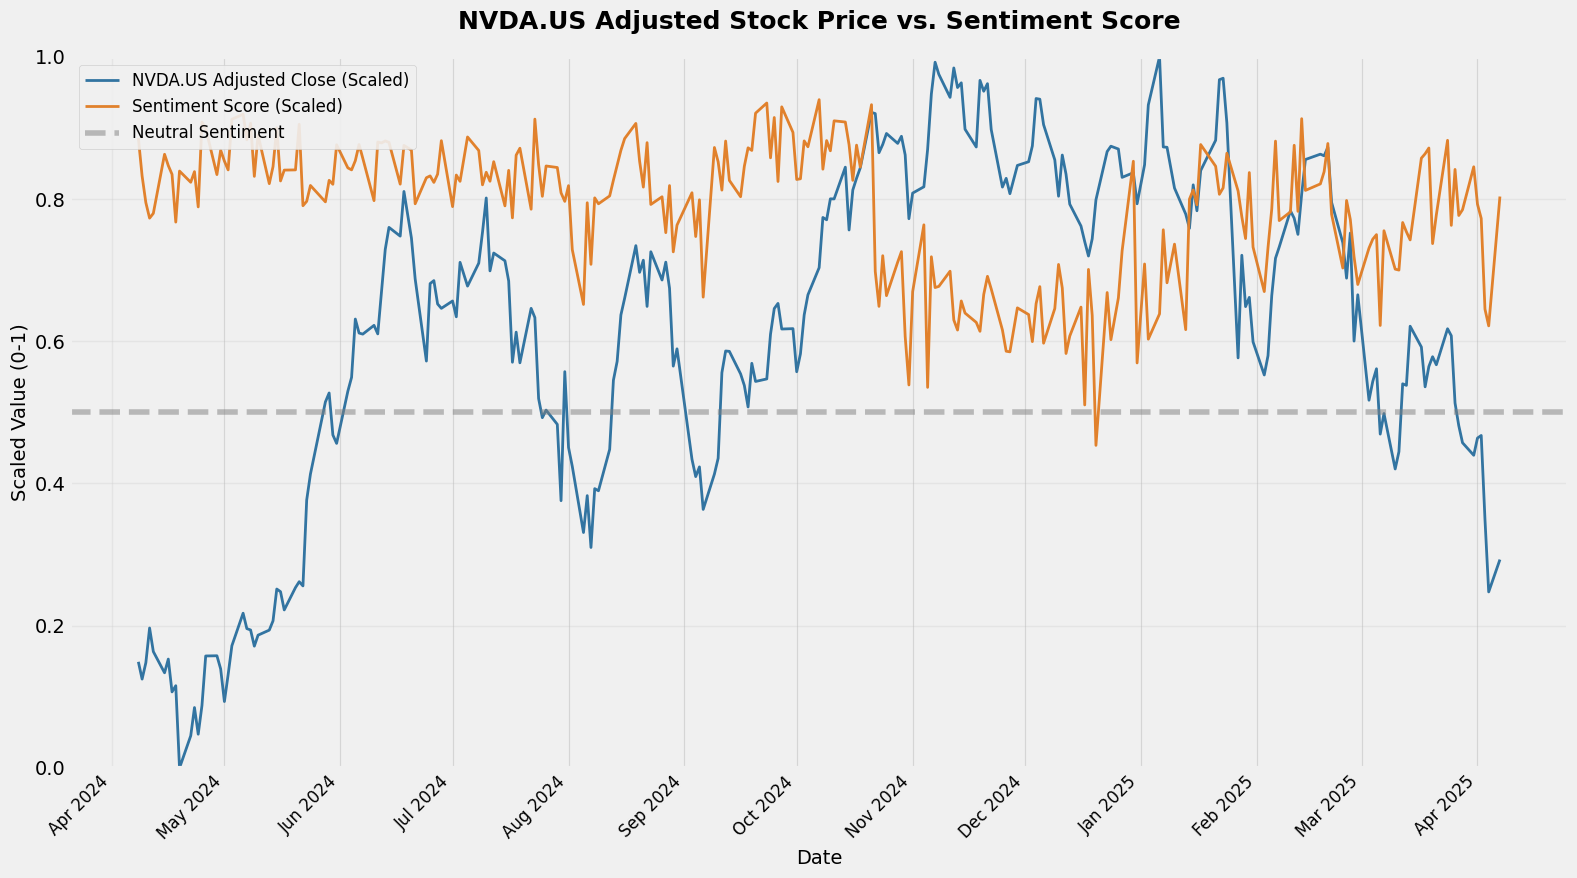

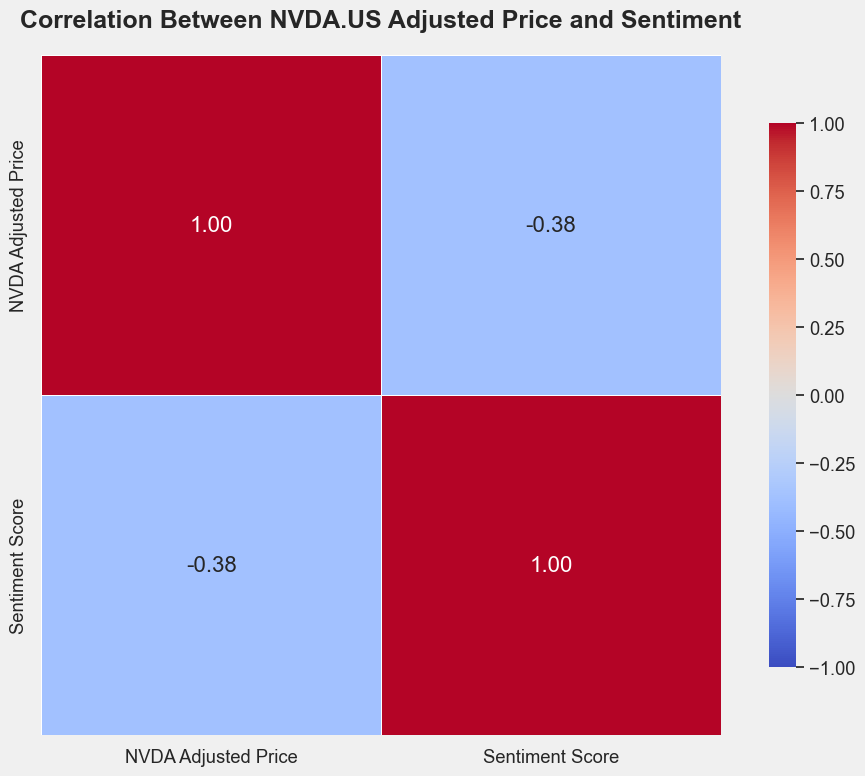

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates

# Define the symbol from the original code
SYMBOL = "NVDA.US"

# Ensure date is datetime
combined_df['date'] = pd.to_datetime(combined_df['date'])

# Create a clean dataframe using adjusted_close instead of close
viz_df = combined_df[['date', 'adjusted_close', 'normalized']].copy()

# Scale both metrics for visualization
# For adjusted_close, scale to 0-1 range
min_price = viz_df['adjusted_close'].min()
max_price = viz_df['adjusted_close'].max()
price_range = max_price - min_price
viz_df['scaled_price'] = (viz_df['adjusted_close'] - min_price) / price_range

# Scale sentiment from -1 to 1 range to 0-1 range
viz_df['scaled_sentiment'] = (viz_df['normalized'] + 1) / 2

# Set the style for the plots
plt.style.use('fivethirtyeight')

# Create the line chart
plt.figure(figsize=(16, 9))

# Plot both metrics
plt.plot(viz_df['date'], viz_df['scaled_price'], color='#3274A1', linewidth=2, 
         label=f'{SYMBOL} Adjusted Close (Scaled)')
plt.plot(viz_df['date'], viz_df['scaled_sentiment'], color='#E1812C', linewidth=2, 
         label='Sentiment Score (Scaled)')

# Add reference line for neutral sentiment
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Neutral Sentiment')

plt.title(f'{SYMBOL} Adjusted Stock Price vs. Sentiment Score', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('Scaled Value (0-1)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylim(0, 1)

# Add legend with larger font
plt.legend(loc='upper left', frameon=True, framealpha=0.9, fontsize=12)

# Format the x-axis to show month labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.setp(plt.gca().get_xticklabels(), rotation=45, ha='right', fontsize=12)
plt.grid(True, alpha=0.3)

# Add vertical month separator lines
for date in pd.date_range(start=viz_df['date'].min(), end=viz_df['date'].max(), freq='MS'):
    plt.axvline(x=date, color='gray', alpha=0.2, linestyle='-', linewidth=0.5)

plt.tight_layout()
# plt.savefig('nvda_adjusted_price_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()

# Create correlation matrix
corr_df = viz_df[['adjusted_close', 'normalized']].copy()
corr_df.columns = ['NVDA Adjusted Price', 'Sentiment Score']  # Rename for clearer labels

# Calculate correlation matrix
correlation_matrix = corr_df.corr()

# Create the correlation heatmap
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)

# Plot the heatmap with values in boxes
sns.heatmap(
    correlation_matrix,
    annot=True,  # Show correlation values
    fmt=".2f",   # Format as 2 decimal places
    cmap='coolwarm',  # Blue-red colormap
    vmin=-1, vmax=1,  # Correlation ranges from -1 to 1
    square=True,  # Square cells
    linewidths=0.5,  # Add grid lines
    cbar_kws={"shrink": 0.8},  # Colorbar settings
    annot_kws={"size": 16}  # Annotation text size
)

plt.title(f'Correlation Between {SYMBOL} Adjusted Price and Sentiment', fontsize=18, fontweight='bold', pad=20)
plt.tight_layout()
# plt.savefig('nvda_adjusted_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

#### Model Building (XGBoost)

Total available rows after adding lagged features: 245
Training set: 196 samples, Test set: 49 samples
Training date range: 2024-04-15 00:00:00 to 2025-01-24 00:00:00
Testing date range: 2025-01-27 00:00:00 to 2025-04-04 00:00:00
Training XGBoost model...
Train RMSE: 0.54
Test RMSE: 8.21
Train MAE: 0.42
Test MAE: 6.31
Train R²: 0.9991
Test R²: 0.4150
Train MAPE: 0.35%
Test MAPE: 5.21%


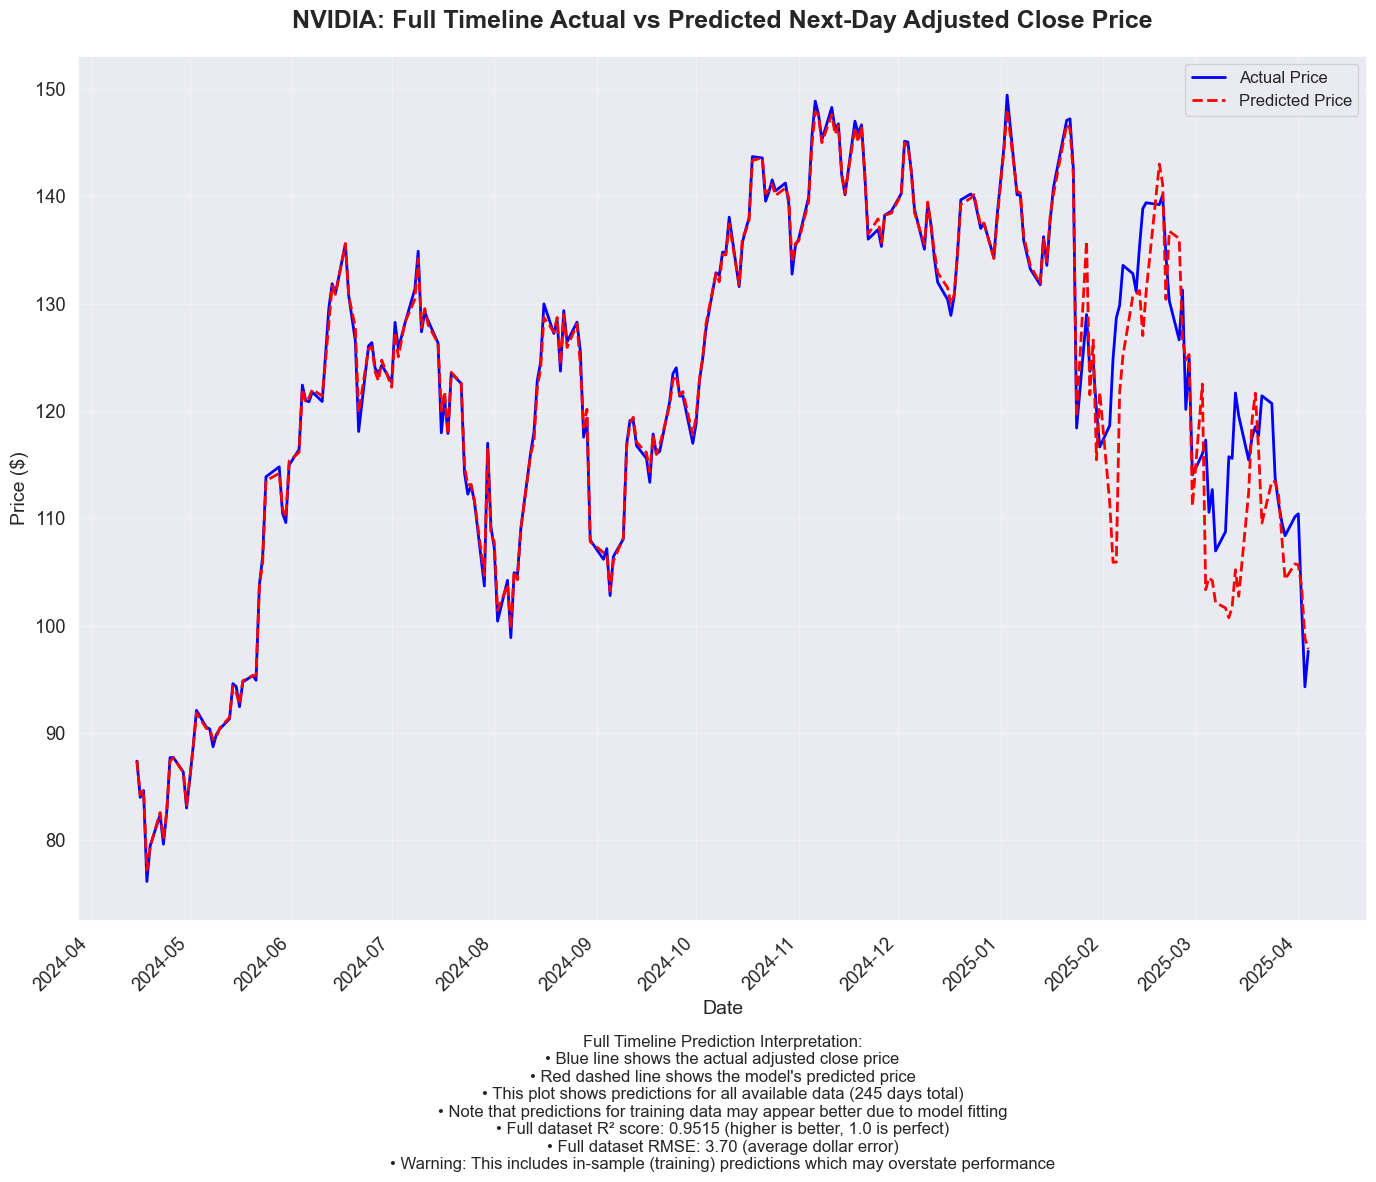

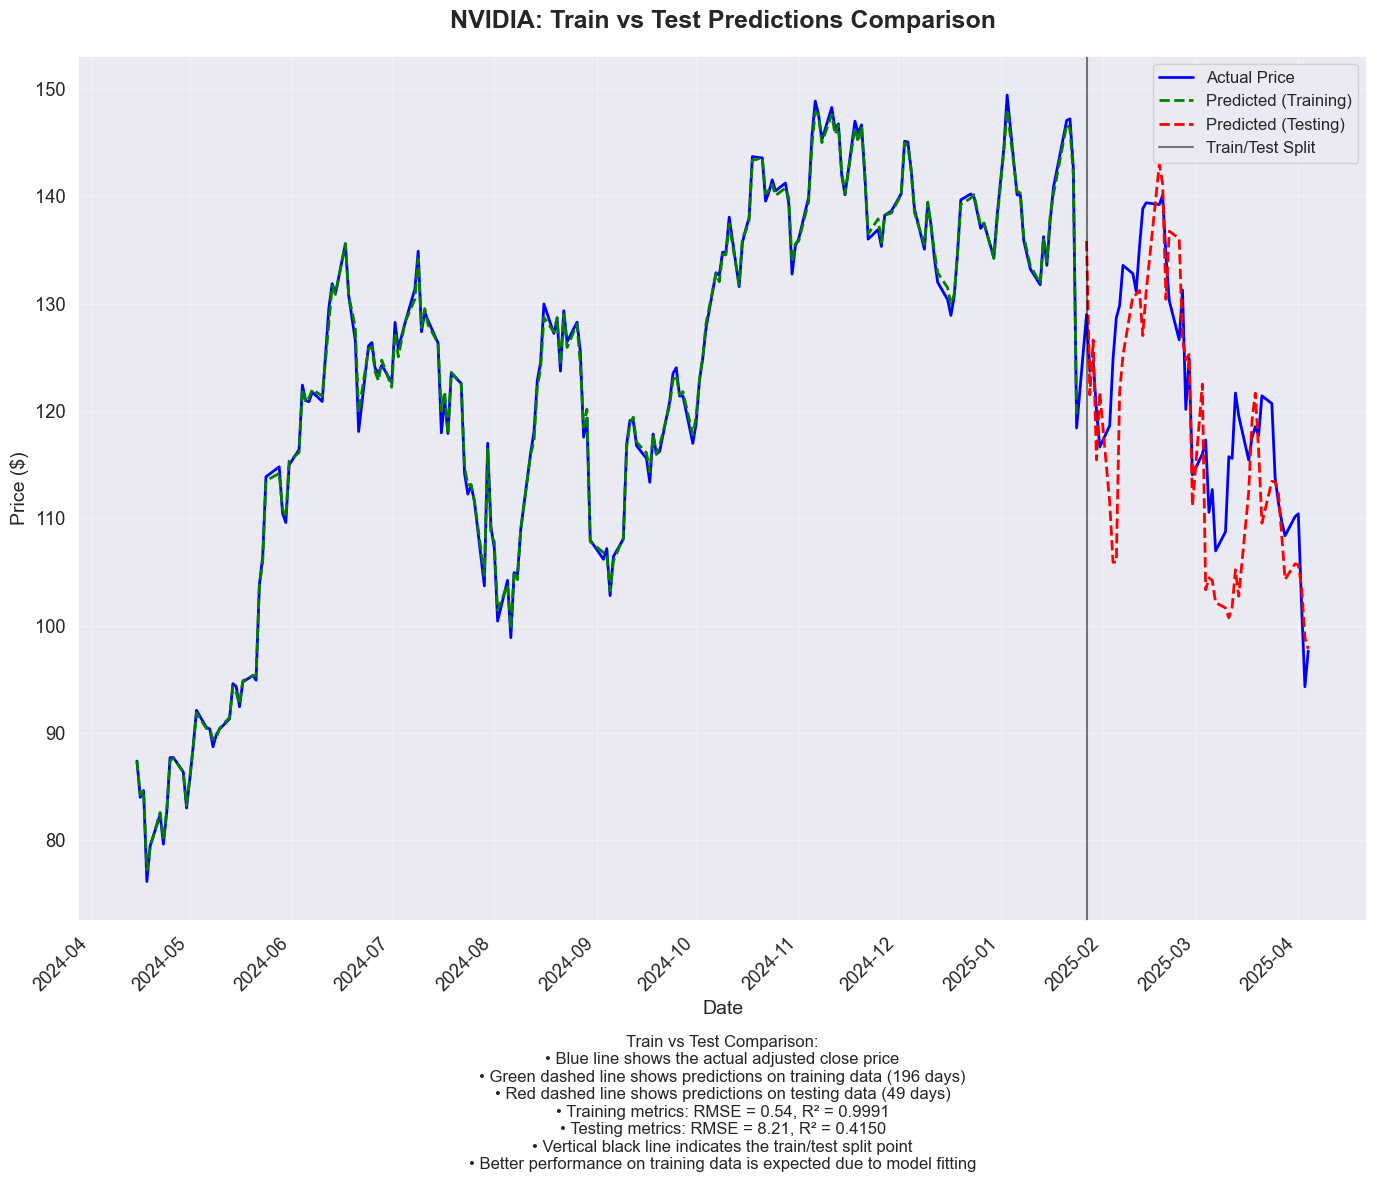

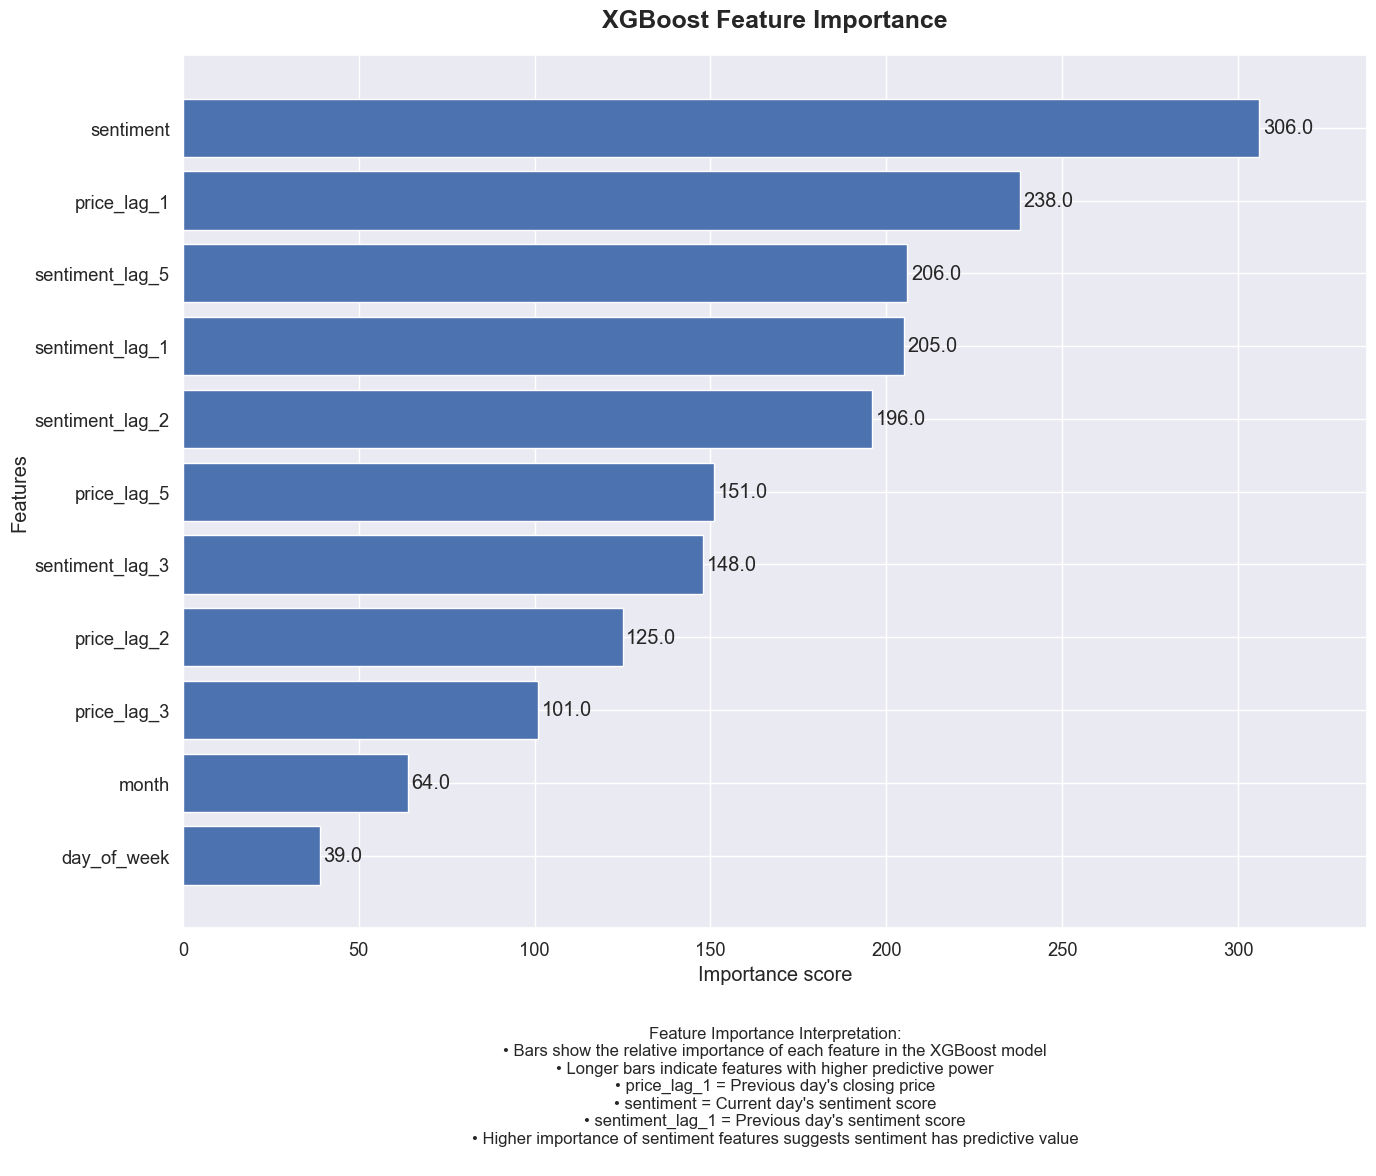

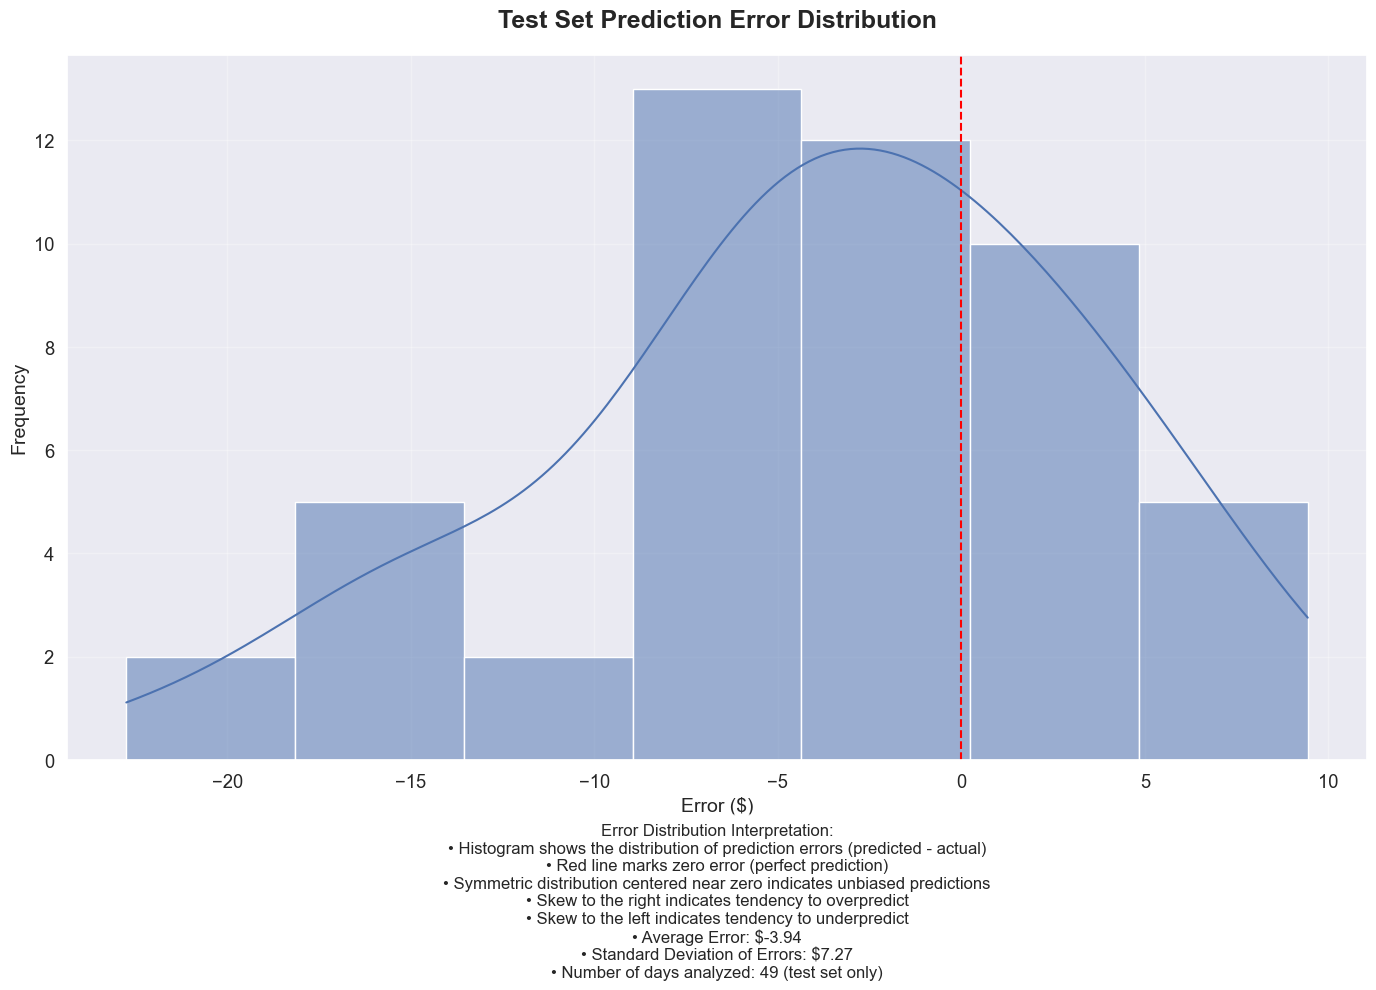

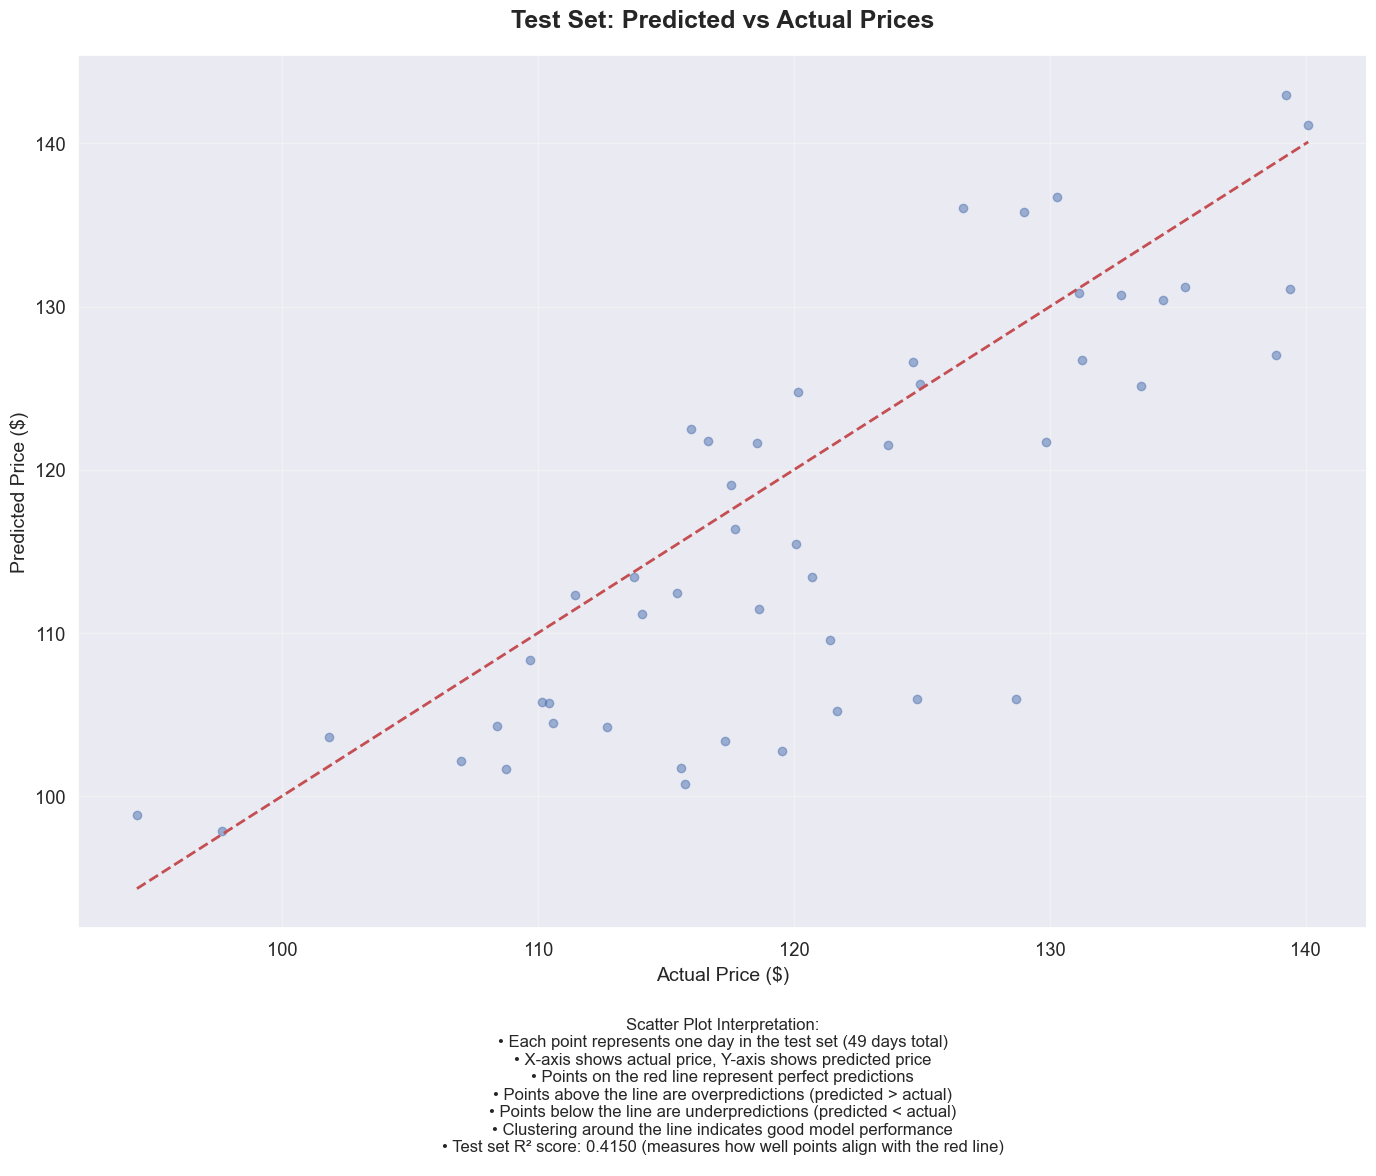

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from datetime import timedelta
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

# Ensure date is datetime
combined_df['date'] = pd.to_datetime(combined_df['date'])

# Create a clean dataframe for modeling
model_df = combined_df[['date', 'adjusted_close', 'normalized']].copy()

# Sort by date to ensure proper sequence
model_df = model_df.sort_values('date')

# Feature Engineering: Create lagged features
# This assumes that today's price might be influenced by sentiment from previous days
lags = [0, 1, 2, 3, 5]  # Today's sentiment and previous days' sentiment
for lag in lags:
    if lag == 0:
        model_df[f'sentiment'] = model_df['normalized']
    else:
        model_df[f'sentiment_lag_{lag}'] = model_df['normalized'].shift(lag)

# Also add price lags since previous prices are strong predictors
for lag in [1, 2, 3, 5]:
    model_df[f'price_lag_{lag}'] = model_df['adjusted_close'].shift(lag)

# Create a 'target' column - next day's adjusted close
model_df['target'] = model_df['adjusted_close'].shift(-1)

# Calculate next-day price change percentage for later analysis
model_df['next_day_change_pct'] = (model_df['target'] / model_df['adjusted_close'] - 1) * 100

# Add day of week as potential feature (0=Monday, 6=Sunday)
model_df['day_of_week'] = model_df['date'].dt.dayofweek

# Add month as potential feature
model_df['month'] = model_df['date'].dt.month

# Drop rows with NaN (due to lagging)
model_df = model_df.dropna()

# Print info about available rows
print(f"Total available rows after adding lagged features: {len(model_df)}")

# Specify features to use in the model
features = [col for col in model_df.columns if col.startswith('sentiment') 
            or col.startswith('price_lag_') 
            or col in ['day_of_week', 'month']]

# Split data into training and testing sets (time-based split)
# Use the last 20% of data for testing
split_idx = int(len(model_df) * 0.8)
train_df = model_df.iloc[:split_idx]
test_df = model_df.iloc[split_idx:]

print(f"Training set: {len(train_df)} samples, Test set: {len(test_df)} samples")
print(f"Training date range: {train_df['date'].min()} to {train_df['date'].max()}")
print(f"Testing date range: {test_df['date'].min()} to {test_df['date'].max()}")

# Prepare X and y for training and testing
X_train = train_df[features]
y_train = train_df['target']
X_test = test_df[features]
y_test = test_df['target']

# Initialize and train the XGBoost model
print("Training XGBoost model...")
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='rmse',
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# Make predictions on training and test sets
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Evaluate the model on training and test sets
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)
train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)

print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Train MAE: {train_mae:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

# Calculate MAPE (Mean Absolute Percentage Error)
train_mape = np.mean(np.abs((y_train - train_predictions) / y_train)) * 100
test_mape = np.mean(np.abs((y_test - test_predictions) / y_test)) * 100
print(f"Train MAPE: {train_mape:.2f}%")
print(f"Test MAPE: {test_mape:.2f}%")

# Create a dataframe with actual vs predicted values for the test set
test_results = test_df.copy()
test_results['predicted'] = test_predictions
test_results['actual'] = test_results['target']

# ==== FULL TIMELINE PREDICTION VISUALIZATION ====

# Make predictions for the entire dataset
all_predictions = model.predict(model_df[features])

# Create a dataframe with actual vs predicted values for the entire timeline
full_timeline = model_df.copy()
full_timeline['predicted'] = all_predictions
full_timeline['actual'] = full_timeline['target']  # Use target as the actual value

# Create the full timeline actual vs predicted chart
plt.figure(figsize=(14, 12))

# Create subplot with room for legend
ax = plt.subplot2grid((5, 1), (0, 0), rowspan=4)

# Plot actual vs predicted prices for the full timeline
ax.plot(full_timeline['date'], full_timeline['actual'], label='Actual Price', color='blue', linewidth=2)
ax.plot(full_timeline['date'], full_timeline['predicted'], label='Predicted Price', color='red', linewidth=2, linestyle='--')
ax.set_title('NVIDIA: Full Timeline Actual vs Predicted Next-Day Adjusted Close Price', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Price ($)', fontsize=14)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

# Format x-axis to show monthly intervals
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Add explanatory text
legend_ax = plt.subplot2grid((5, 1), (4, 0), rowspan=1)
legend_ax.axis('off')

# Calculate metrics for the entire dataset
full_rmse = np.sqrt(mean_squared_error(full_timeline['actual'], full_timeline['predicted']))
full_r2 = r2_score(full_timeline['actual'], full_timeline['predicted'])

prediction_explanation = """Full Timeline Prediction Interpretation:
• Blue line shows the actual adjusted close price
• Red dashed line shows the model's predicted price
• This plot shows predictions for all available data ({} days total)
• Note that predictions for training data may appear better due to model fitting
• Full dataset R² score: {:.4f} (higher is better, 1.0 is perfect)
• Full dataset RMSE: {:.2f} (average dollar error)
• Warning: This includes in-sample (training) predictions which may overstate performance""".format(
    len(full_timeline),
    full_r2,
    full_rmse
)

legend_ax.text(0.5, 0.5, prediction_explanation, ha='center', va='center', fontsize=12,
               bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()

# ==== TRAIN VS TEST COMPARISON VISUALIZATION ====

# Create a version with clear train/test split visualization
plt.figure(figsize=(14, 12))

# Create subplot
ax = plt.subplot2grid((5, 1), (0, 0), rowspan=4)

# Calculate the split date for visualization
split_date = model_df.iloc[split_idx]['date']

# Plot actual prices
ax.plot(full_timeline['date'], full_timeline['actual'], label='Actual Price', color='blue', linewidth=2)

# Plot predicted prices with different colors for train and test
train_mask = full_timeline['date'] < split_date
test_mask = full_timeline['date'] >= split_date

ax.plot(full_timeline.loc[train_mask, 'date'], full_timeline.loc[train_mask, 'predicted'], 
        label='Predicted (Training)', color='green', linewidth=2, linestyle='--')
ax.plot(full_timeline.loc[test_mask, 'date'], full_timeline.loc[test_mask, 'predicted'], 
        label='Predicted (Testing)', color='red', linewidth=2, linestyle='--')

# Add vertical line at train/test split
ax.axvline(x=split_date, color='black', linestyle='-', alpha=0.5, label='Train/Test Split')

ax.set_title('NVIDIA: Train vs Test Predictions Comparison', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Price ($)', fontsize=14)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

# Format x-axis to show monthly intervals
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Add explanatory text
legend_ax = plt.subplot2grid((5, 1), (4, 0), rowspan=1)
legend_ax.axis('off')

train_rmse = np.sqrt(mean_squared_error(full_timeline.loc[train_mask, 'actual'], full_timeline.loc[train_mask, 'predicted']))
train_r2 = r2_score(full_timeline.loc[train_mask, 'actual'], full_timeline.loc[train_mask, 'predicted'])
test_rmse = np.sqrt(mean_squared_error(full_timeline.loc[test_mask, 'actual'], full_timeline.loc[test_mask, 'predicted']))
test_r2 = r2_score(full_timeline.loc[test_mask, 'actual'], full_timeline.loc[test_mask, 'predicted'])

comparison_explanation = """Train vs Test Comparison:
• Blue line shows the actual adjusted close price
• Green dashed line shows predictions on training data ({} days)
• Red dashed line shows predictions on testing data ({} days)
• Training metrics: RMSE = {:.2f}, R² = {:.4f}
• Testing metrics: RMSE = {:.2f}, R² = {:.4f}
• Vertical black line indicates the train/test split point
• Better performance on training data is expected due to model fitting""".format(
    train_mask.sum(),
    test_mask.sum(),
    train_rmse,
    train_r2,
    test_rmse,
    test_r2
)

legend_ax.text(0.5, 0.5, comparison_explanation, ha='center', va='center', fontsize=12,
               bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()

# ==== FEATURE IMPORTANCE VISUALIZATION ====
plt.figure(figsize=(14, 12))

# Create subplot with room for legend
ax = plt.subplot2grid((5, 1), (0, 0), rowspan=4)

# Plot feature importance
xgb.plot_importance(model, importance_type='weight', height=0.8, ax=ax)
ax.set_title('XGBoost Feature Importance', fontsize=18, fontweight='bold', pad=20)

# Create a dedicated subplot for the legend
legend_ax = plt.subplot2grid((5, 1), (4, 0), rowspan=1)
legend_ax.axis('off')

# Add explanatory text in the dedicated legend area
importance_explanation = """Feature Importance Interpretation:
• Bars show the relative importance of each feature in the XGBoost model
• Longer bars indicate features with higher predictive power
• price_lag_1 = Previous day's closing price
• sentiment = Current day's sentiment score
• sentiment_lag_1 = Previous day's sentiment score
• Higher importance of sentiment features suggests sentiment has predictive value"""

legend_ax.text(0.5, 0.5, importance_explanation, ha='center', va='center', fontsize=12,
               bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()

# ==== ERROR DISTRIBUTION (TEST SET ONLY) ====
plt.figure(figsize=(14, 10))

# Create subplot with room for legend
ax = plt.subplot2grid((5, 1), (0, 0), rowspan=4)

# Calculate and plot error distribution for test set
errors = test_results['predicted'] - test_results['actual']
sns.histplot(errors, kde=True, ax=ax)
ax.set_title('Test Set Prediction Error Distribution', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Error ($)', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.axvline(x=0, color='red', linestyle='--')
ax.grid(True, alpha=0.3)

# Create a dedicated subplot for the legend
legend_ax = plt.subplot2grid((5, 1), (4, 0), rowspan=1)
legend_ax.axis('off')

# Add explanatory text in the dedicated legend area
error_explanation = """Error Distribution Interpretation:
• Histogram shows the distribution of prediction errors (predicted - actual)
• Red line marks zero error (perfect prediction)
• Symmetric distribution centered near zero indicates unbiased predictions
• Skew to the right indicates tendency to overpredict
• Skew to the left indicates tendency to underpredict
• Average Error: ${:.2f}
• Standard Deviation of Errors: ${:.2f}
• Number of days analyzed: {} (test set only)""".format(
    errors.mean(), 
    errors.std(),
    len(errors)
)

legend_ax.text(0.5, 0.5, error_explanation, ha='center', va='center', fontsize=12,
               bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()

# ==== SCATTER PLOT (TEST SET ONLY) ====
plt.figure(figsize=(14, 12))

# Create subplot with room for legend
ax = plt.subplot2grid((5, 1), (0, 0), rowspan=4)

# Create scatter plot for test set
ax.scatter(test_results['actual'], test_results['predicted'], alpha=0.5)
ax.plot([test_results['actual'].min(), test_results['actual'].max()], 
        [test_results['actual'].min(), test_results['actual'].max()], 
        'r--', linewidth=2)
ax.set_title('Test Set: Predicted vs Actual Prices', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Actual Price ($)', fontsize=14)
ax.set_ylabel('Predicted Price ($)', fontsize=14)
ax.grid(True, alpha=0.3)

# Create a dedicated subplot for the legend
legend_ax = plt.subplot2grid((5, 1), (4, 0), rowspan=1)
legend_ax.axis('off')

# Add explanatory text in the dedicated legend area
scatter_explanation = """Scatter Plot Interpretation:
• Each point represents one day in the test set ({} days total)
• X-axis shows actual price, Y-axis shows predicted price
• Points on the red line represent perfect predictions
• Points above the line are overpredictions (predicted > actual)
• Points below the line are underpredictions (predicted < actual)
• Clustering around the line indicates good model performance
• Test set R² score: {:.4f} (measures how well points align with the red line)""".format(
    len(test_results),
    test_r2
)

legend_ax.text(0.5, 0.5, scatter_explanation, ha='center', va='center', fontsize=12,
               bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()

#### Model Building To Handle Robustness & Overfitting


===== 1. Base Model with Time Series Cross-Validation =====
Fold 1: RMSE=6.3039, R²=0.5440, MAE=5.0922, Period: 2024-06-18 to 2024-08-14
Fold 2: RMSE=4.8555, R²=0.6390, MAE=4.0044, Period: 2024-08-15 to 2024-10-10
Fold 3: RMSE=24.5287, R²=-29.9861, MAE=23.3995, Period: 2024-10-11 to 2024-12-06
Fold 4: RMSE=9.5239, R²=-0.4636, MAE=7.7527, Period: 2024-12-09 to 2025-02-06
Fold 5: RMSE=6.0804, R²=0.7221, MAE=4.9013, Period: 2025-02-07 to 2025-04-04

Overall Base Model Performance:
RMSE: 12.5908
R²: -0.0212
MAE: 9.0300

===== 2. Walk Forward Optimization =====
Performing walk-forward optimization with 6 iterations
Initial training size: 122 samples
Test window size: 20 samples
Fold 1/6: RMSE=19.2258, R²=-29.7149, MAE=17.9119, Period: 2024-10-08 to 2024-11-04
Fold 2/6: RMSE=8.4363, R²=-2.8841, MAE=7.4685, Period: 2024-11-05 to 2024-12-03
Fold 3/6: RMSE=7.4090, R²=-1.8512, MAE=6.1785, Period: 2024-12-04 to 2025-01-02
Fold 4/6: RMSE=8.4093, R²=0.2895, MAE=6.5979, Period: 2025-01-03 to 2025-0

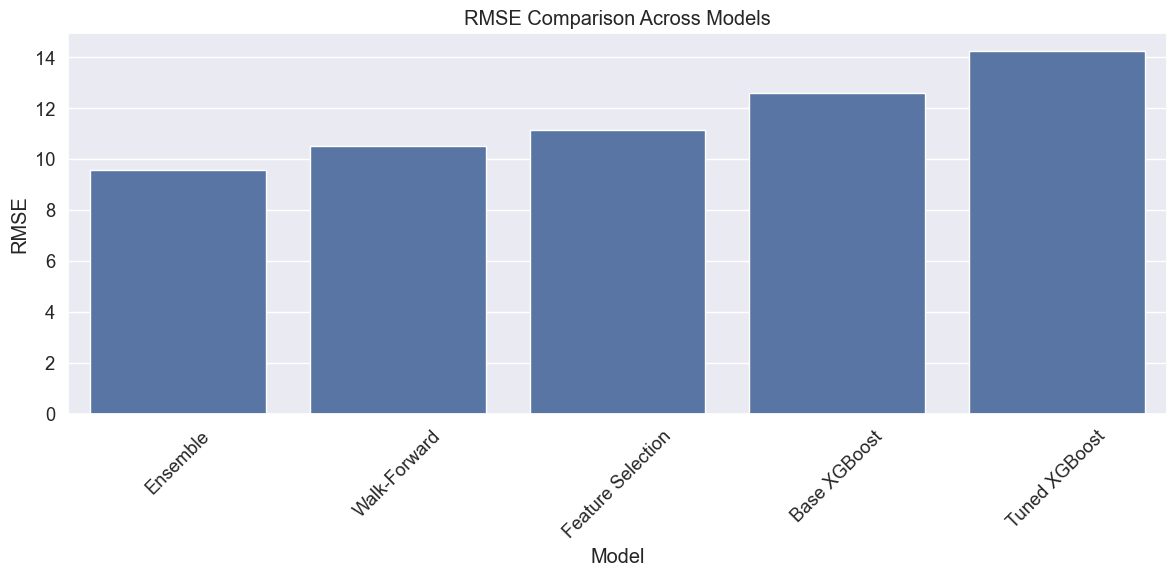

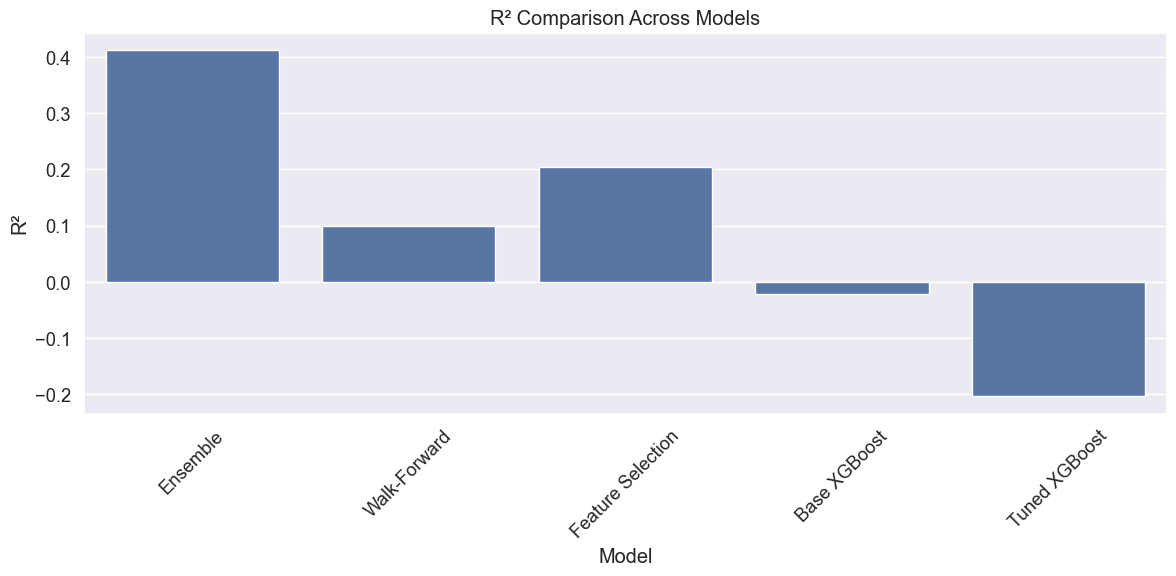

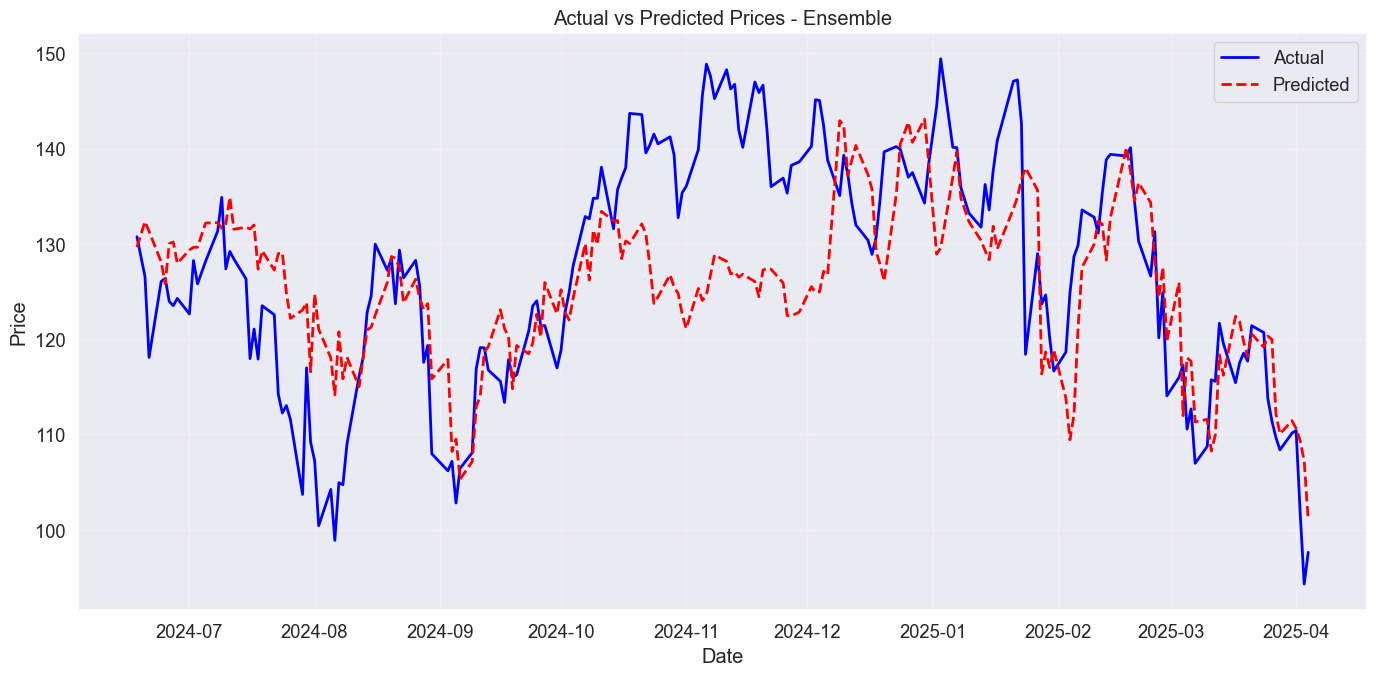

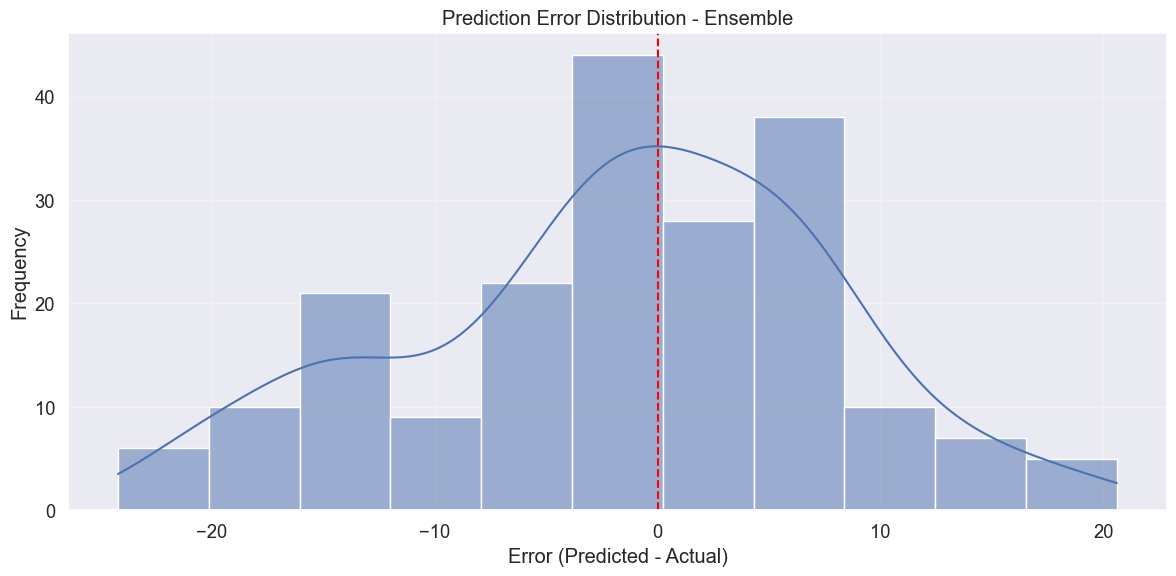

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge, Lasso
import xgboost as xgb
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

#---------------------------------------
# 1. Base Model Evaluation with Time Series Cross-Validation
#---------------------------------------
def evaluate_base_model_with_tscv(model_df, features, target_col='target', n_splits=5):
    """
    Evaluate the base model using time series cross-validation
    """
    print("\n===== 1. Base Model with Time Series Cross-Validation =====")
    
    # Prepare data
    X = model_df[features]
    y = model_df[target_col]
    dates = model_df['date']
    
    # Initialize time series cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Results storage
    fold_metrics = []
    all_dates = []
    all_actuals = []
    all_predictions = []
    
    # Base XGBoost model
    base_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='rmse',
        random_state=42
    )
    
    # Perform time series cross-validation
    for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        dates_test = dates.iloc[test_idx]
        
        # Fit model
        base_model.fit(X_train, y_train)
        
        # Predict
        y_pred = base_model.predict(X_test)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        
        # Store results
        fold_metrics.append({
            'fold': i+1,
            'rmse': rmse,
            'r2': r2,
            'mae': mae,
            'train_size': len(X_train),
            'test_size': len(X_test),
            'test_start': dates_test.min(),
            'test_end': dates_test.max()
        })
        
        all_dates.extend(dates_test)
        all_actuals.extend(y_test)
        all_predictions.extend(y_pred)
        
        print(f"Fold {i+1}: RMSE={rmse:.4f}, R²={r2:.4f}, MAE={mae:.4f}, "
              f"Period: {dates_test.min().strftime('%Y-%m-%d')} to {dates_test.max().strftime('%Y-%m-%d')}")
    
    # Calculate overall metrics
    overall_rmse = np.sqrt(mean_squared_error(all_actuals, all_predictions))
    overall_r2 = r2_score(all_actuals, all_predictions)
    overall_mae = mean_absolute_error(all_actuals, all_predictions)
    
    print(f"\nOverall Base Model Performance:")
    print(f"RMSE: {overall_rmse:.4f}")
    print(f"R²: {overall_r2:.4f}")
    print(f"MAE: {overall_mae:.4f}")
    
    # Compile results
    base_results = pd.DataFrame({
        'date': all_dates,
        'actual': all_actuals,
        'predicted': all_predictions,
        'model': 'Base XGBoost'
    })
    
    fold_metrics_df = pd.DataFrame(fold_metrics)
    
    return {
        'results': base_results,
        'metrics': fold_metrics_df,
        'overall_metrics': {
            'rmse': overall_rmse,
            'r2': overall_r2,
            'mae': overall_mae
        }
    }

#---------------------------------------
# 2. Walk Forward Optimization
#---------------------------------------
def walk_forward_optimization(model_df, features, target_col='target', initial_train_size=0.5, test_window_size=20):
    """
    Implement walk-forward optimization for model evaluation
    """
    print("\n===== 2. Walk Forward Optimization =====")
    
    # Ensure dataframe is sorted by date
    model_df = model_df.sort_values('date')
    
    # Calculate initial train size
    if isinstance(initial_train_size, float):
        initial_train_size = int(len(model_df) * initial_train_size)
    
    # Results storage
    all_dates = []
    all_actuals = []
    all_predictions = []
    fold_metrics = []
    
    # Number of iterations
    n_iterations = (len(model_df) - initial_train_size) // test_window_size
    if n_iterations < 1:
        n_iterations = 1
        test_window_size = len(model_df) - initial_train_size
    
    print(f"Performing walk-forward optimization with {n_iterations} iterations")
    print(f"Initial training size: {initial_train_size} samples")
    print(f"Test window size: {test_window_size} samples")
    
    for i in range(n_iterations):
        # Define train/test ranges for this iteration
        train_end = initial_train_size + i * test_window_size
        test_start = train_end
        test_end = min(test_start + test_window_size, len(model_df))
        
        # Get train/test sets
        train_df = model_df.iloc[:train_end]
        test_df = model_df.iloc[test_start:test_end]
        
        # Prepare features and target
        X_train = train_df[features]
        y_train = train_df[target_col]
        X_test = test_df[features]
        y_test = test_df[target_col]
        
        # Train model
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric='rmse',
            random_state=42
        )
        model.fit(X_train, y_train)
        
        # Make predictions
        predictions = model.predict(X_test)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        r2 = r2_score(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)
        
        # Store results
        all_dates.extend(test_df['date'])
        all_actuals.extend(y_test)
        all_predictions.extend(predictions)
        
        fold_metrics.append({
            'fold': i+1,
            'rmse': rmse,
            'r2': r2,
            'mae': mae,
            'train_size': len(X_train),
            'test_size': len(X_test),
            'test_start': test_df['date'].min(),
            'test_end': test_df['date'].max()
        })
        
        print(f"Fold {i+1}/{n_iterations}: RMSE={rmse:.4f}, R²={r2:.4f}, MAE={mae:.4f}, "
              f"Period: {test_df['date'].min().strftime('%Y-%m-%d')} to {test_df['date'].max().strftime('%Y-%m-%d')}")
    
    # Calculate overall metrics
    overall_rmse = np.sqrt(mean_squared_error(all_actuals, all_predictions))
    overall_r2 = r2_score(all_actuals, all_predictions)
    overall_mae = mean_absolute_error(all_actuals, all_predictions)
    
    print(f"\nOverall Walk-Forward Model Performance:")
    print(f"RMSE: {overall_rmse:.4f}")
    print(f"R²: {overall_r2:.4f}")
    print(f"MAE: {overall_mae:.4f}")
    
    # Compile results
    wf_results = pd.DataFrame({
        'date': all_dates,
        'actual': all_actuals,
        'predicted': all_predictions,
        'model': 'Walk-Forward XGBoost'
    })
    
    fold_metrics_df = pd.DataFrame(fold_metrics)
    
    return {
        'results': wf_results,
        'metrics': fold_metrics_df,
        'overall_metrics': {
            'rmse': overall_rmse,
            'r2': overall_r2,
            'mae': overall_mae
        }
    }

#---------------------------------------
# 3. Hyperparameter Tuning with Time Series CV
#---------------------------------------
def hyperparameter_tuning(model_df, features, target_col='target', n_splits=3, quick_mode=True):
    """
    Tune XGBoost hyperparameters using time series cross-validation
    """
    print("\n===== 3. Hyperparameter Tuning with Time Series CV =====")
    
    # Prepare data
    X = model_df[features]
    y = model_df[target_col]
    
    # Define parameter grid (smaller in quick mode)
    if quick_mode:
        param_grid = {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
            'min_child_weight': [1, 3]
        }
    else:
        param_grid = {
            'n_estimators': [50, 100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7, 9],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'min_child_weight': [1, 3, 5],
            'gamma': [0, 0.1, 0.2]
        }
    
    # Initialize time series cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Initialize model
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        eval_metric='rmse',
        random_state=42
    )
    
    # Perform grid search with time series CV
    grid_search = GridSearchCVCustom(
        model, 
        param_grid,
        cv=tscv,
        model_df=model_df,
        features=features,
        target_col=target_col
    )
    
    # Get best parameters and model
    best_params = grid_search['best_params']
    
    print("\nBest Hyperparameters:")
    for param, value in best_params.items():
        print(f"{param}: {value}")
    
    # Train final model with best parameters
    best_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        eval_metric='rmse',
        random_state=42,
        **best_params
    )
    
    # Evaluate tuned model with time series CV
    results = evaluate_tuned_model_with_tscv(
        model_df, 
        features, 
        target_col, 
        best_model, 
        n_splits
    )
    
    return {
        'results': results['results'],
        'metrics': results['metrics'],
        'overall_metrics': results['overall_metrics'],
        'best_params': best_params,
        'best_model': best_model
    }

def GridSearchCVCustom(model, param_grid, cv, model_df, features, target_col):
    """
    Custom implementation of grid search for time series data
    (simplified for your specific case)
    """
    # Storage for results
    results = []
    
    # Get all parameter combinations
    from itertools import product
    keys = list(param_grid.keys())
    values = list(param_grid.values())
    param_combinations = [dict(zip(keys, combo)) for combo in product(*values)]
    
    print(f"Testing {len(param_combinations)} parameter combinations...")
    
    # Iterate through parameter combinations
    best_score = float('inf')
    best_params = None
    
    for i, params in enumerate(param_combinations):
        if i % 5 == 0:  # Print progress every 5 combinations
            print(f"Testing combination {i+1}/{len(param_combinations)}")
            
        # Create model with current parameters
        current_model = xgb.XGBRegressor(
            objective='reg:squarederror',
            eval_metric='rmse',
            random_state=42,
            **params
        )
        
        # Evaluate with time series CV
        cv_rmse_values = []
        
        for train_idx, test_idx in cv.split(model_df):
            train_df = model_df.iloc[train_idx]
            test_df = model_df.iloc[test_idx]
            
            X_train = train_df[features]
            y_train = train_df[target_col]
            X_test = test_df[features]
            y_test = test_df[target_col]
            
            # Train and predict
            current_model.fit(X_train, y_train)
            y_pred = current_model.predict(X_test)
            
            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            cv_rmse_values.append(rmse)
        
        # Calculate mean RMSE across folds
        mean_rmse = np.mean(cv_rmse_values)
        
        # Save result
        results.append({
            'params': params,
            'mean_rmse': mean_rmse,
            'std_rmse': np.std(cv_rmse_values)
        })
        
        # Update best parameters if better
        if mean_rmse < best_score:
            best_score = mean_rmse
            best_params = params
    
    # Print best result
    print(f"\nBest CV RMSE: {best_score:.4f}")
    
    return {
        'best_params': best_params,
        'best_score': best_score,
        'results': results
    }

def evaluate_tuned_model_with_tscv(model_df, features, target_col, tuned_model, n_splits):
    """
    Evaluate the tuned model using time series cross-validation
    """
    print("\nEvaluating tuned model with time series cross-validation...")
    
    # Prepare data
    X = model_df[features]
    y = model_df[target_col]
    dates = model_df['date']
    
    # Initialize time series cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Results storage
    fold_metrics = []
    all_dates = []
    all_actuals = []
    all_predictions = []
    
    # Perform time series cross-validation
    for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        dates_test = dates.iloc[test_idx]
        
        # Fit model
        tuned_model.fit(X_train, y_train)
        
        # Predict
        y_pred = tuned_model.predict(X_test)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        
        # Store results
        fold_metrics.append({
            'fold': i+1,
            'rmse': rmse,
            'r2': r2,
            'mae': mae,
            'train_size': len(X_train),
            'test_size': len(X_test),
            'test_start': dates_test.min(),
            'test_end': dates_test.max()
        })
        
        all_dates.extend(dates_test)
        all_actuals.extend(y_test)
        all_predictions.extend(y_pred)
        
        print(f"Fold {i+1}: RMSE={rmse:.4f}, R²={r2:.4f}, MAE={mae:.4f}, "
              f"Period: {dates_test.min().strftime('%Y-%m-%d')} to {dates_test.max().strftime('%Y-%m-%d')}")
    
    # Calculate overall metrics
    overall_rmse = np.sqrt(mean_squared_error(all_actuals, all_predictions))
    overall_r2 = r2_score(all_actuals, all_predictions)
    overall_mae = mean_absolute_error(all_actuals, all_predictions)
    
    print(f"\nOverall Tuned Model Performance:")
    print(f"RMSE: {overall_rmse:.4f}")
    print(f"R²: {overall_r2:.4f}")
    print(f"MAE: {overall_mae:.4f}")
    
    # Compile results
    tuned_results = pd.DataFrame({
        'date': all_dates,
        'actual': all_actuals,
        'predicted': all_predictions,
        'model': 'Tuned XGBoost'
    })
    
    fold_metrics_df = pd.DataFrame(fold_metrics)
    
    return {
        'results': tuned_results,
        'metrics': fold_metrics_df,
        'overall_metrics': {
            'rmse': overall_rmse,
            'r2': overall_r2,
            'mae': overall_mae
        }
    }

#---------------------------------------
# 4. Feature Selection and Dimensionality Reduction
#---------------------------------------
def feature_selection_and_reduction(model_df, features, target_col='target', n_splits=5):
    """
    Apply feature selection and dimensionality reduction
    """
    print("\n===== 4. Feature Selection and Dimensionality Reduction =====")
    
    # Prepare data
    X = model_df[features]
    y = model_df[target_col]
    dates = model_df['date']
    
    # 4.1 Feature selection using XGBoost's feature importance
    print("\n4.1 XGBoost Feature Importance Selection")
    
    # Train a model on all data to get feature importance
    selector_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
    selector_model.fit(X, y)
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': selector_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Select top features (50% of original features)
    n_top_features = max(3, len(features) // 2)
    top_features = feature_importance['feature'].iloc[:n_top_features].tolist()
    
    print(f"Selected {len(top_features)} out of {len(features)} features based on importance")
    print("Top 5 features:", top_features[:5])
    
    # 4.2 Apply PCA for dimensionality reduction (optional)
    print("\n4.2 PCA Dimensionality Reduction")
    
    # Create pipeline with standardization and PCA
    pca_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95))  # Retain 95% of variance
    ])
    
    # Fit PCA on all data to see how many components are retained
    pca_pipeline.fit(X)
    n_components = pca_pipeline.named_steps['pca'].n_components_
    explained_variance = pca_pipeline.named_steps['pca'].explained_variance_ratio_.sum()
    
    print(f"PCA retained {n_components} components out of {X.shape[1]} features")
    print(f"Explained variance: {explained_variance:.2%}")
    
    # 4.3 Evaluate model with selected features
    print("\n4.3 Evaluating Model with Selected Features")
    
    # Initialize time series cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Results storage for feature selection
    fs_dates = []
    fs_actuals = []
    fs_predictions = []
    fs_fold_metrics = []
    
    # Model for feature selection approach
    fs_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='rmse',
        random_state=42
    )
    
    # Time series CV for feature selection approach
    for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        dates_test = dates.iloc[test_idx]
        
        # Use only top features
        X_train_fs = X_train[top_features]
        X_test_fs = X_test[top_features]
        
        # Fit model
        fs_model.fit(X_train_fs, y_train)
        
        # Predict
        y_pred = fs_model.predict(X_test_fs)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        
        # Store results
        fs_fold_metrics.append({
            'fold': i+1,
            'rmse': rmse,
            'r2': r2,
            'mae': mae,
            'train_size': len(X_train),
            'test_size': len(X_test),
            'test_start': dates_test.min(),
            'test_end': dates_test.max()
        })
        
        fs_dates.extend(dates_test)
        fs_actuals.extend(y_test)
        fs_predictions.extend(y_pred)
        
        print(f"FS Fold {i+1}: RMSE={rmse:.4f}, R²={r2:.4f}, MAE={mae:.4f}, "
              f"Period: {dates_test.min().strftime('%Y-%m-%d')} to {dates_test.max().strftime('%Y-%m-%d')}")
    
    # Calculate overall metrics for feature selection
    fs_overall_rmse = np.sqrt(mean_squared_error(fs_actuals, fs_predictions))
    fs_overall_r2 = r2_score(fs_actuals, fs_predictions)
    fs_overall_mae = mean_absolute_error(fs_actuals, fs_predictions)
    
    print(f"\nOverall Feature Selection Model Performance:")
    print(f"RMSE: {fs_overall_rmse:.4f}")
    print(f"R²: {fs_overall_r2:.4f}")
    print(f"MAE: {fs_overall_mae:.4f}")
    
    # 4.4 Evaluate model with PCA
    print("\n4.4 Evaluating Model with PCA")
    
    # Results storage for PCA
    pca_dates = []
    pca_actuals = []
    pca_predictions = []
    pca_fold_metrics = []
    
    # Time series CV for PCA approach
    for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        dates_test = dates.iloc[test_idx]
        
        # Apply PCA transformation
        pca_pipeline.fit(X_train)
        X_train_pca = pca_pipeline.transform(X_train)
        X_test_pca = pca_pipeline.transform(X_test)
        
        # Fit model on PCA components
        pca_model = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric='rmse',
            random_state=42
        )
        pca_model.fit(X_train_pca, y_train)
        
        # Predict
        y_pred = pca_model.predict(X_test_pca)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        
        # Store results
        pca_fold_metrics.append({
            'fold': i+1,
            'rmse': rmse,
            'r2': r2,
            'mae': mae,
            'train_size': len(X_train),
            'test_size': len(X_test),
            'test_start': dates_test.min(),
            'test_end': dates_test.max()
        })
        
        pca_dates.extend(dates_test)
        pca_actuals.extend(y_test)
        pca_predictions.extend(y_pred)
        
        print(f"PCA Fold {i+1}: RMSE={rmse:.4f}, R²={r2:.4f}, MAE={mae:.4f}, "
              f"Period: {dates_test.min().strftime('%Y-%m-%d')} to {dates_test.max().strftime('%Y-%m-%d')}")
    
    # Calculate overall metrics for PCA
    pca_overall_rmse = np.sqrt(mean_squared_error(pca_actuals, pca_predictions))
    pca_overall_r2 = r2_score(pca_actuals, pca_predictions)
    pca_overall_mae = mean_absolute_error(pca_actuals, pca_predictions)
    
    print(f"\nOverall PCA Model Performance:")
    print(f"RMSE: {pca_overall_rmse:.4f}")
    print(f"R²: {pca_overall_r2:.4f}")
    print(f"MAE: {pca_overall_mae:.4f}")
    
    # Compile all results
    fs_results = pd.DataFrame({
        'date': fs_dates,
        'actual': fs_actuals,
        'predicted': fs_predictions,
        'model': 'Feature Selection'
    })
    
    pca_results = pd.DataFrame({
        'date': pca_dates,
        'actual': pca_actuals,
        'predicted': pca_predictions,
        'model': 'PCA'
    })
    
    # Use the better of the two approaches
    if fs_overall_rmse < pca_overall_rmse:
        print("\nFeature Selection outperformed PCA")
        best_approach = 'Feature Selection'
        best_results = fs_results
        best_metrics = pd.DataFrame(fs_fold_metrics)
        best_overall_metrics = {
            'rmse': fs_overall_rmse,
            'r2': fs_overall_r2,
            'mae': fs_overall_mae
        }
        best_features = top_features
    else:
        print("\nPCA outperformed Feature Selection")
        best_approach = 'PCA'
        best_results = pca_results
        best_metrics = pd.DataFrame(pca_fold_metrics)
        best_overall_metrics = {
            'rmse': pca_overall_rmse,
            'r2': pca_overall_r2,
            'mae': pca_overall_mae
        }
        best_features = None  # PCA doesn't use original features
    
    return {
        'results': best_results,
        'metrics': best_metrics,
        'overall_metrics': best_overall_metrics,
        'best_approach': best_approach,
        'selected_features': best_features,
        'all_results': {
            'fs': fs_results,
            'pca': pca_results
        }
    }

#---------------------------------------
# 5. Ensemble Methods
#---------------------------------------
def ensemble_methods(model_df, features, target_col='target', n_splits=5):
    """
    Implement ensemble methods for improved predictions
    """
    print("\n===== 5. Ensemble Methods =====")
    
    # Prepare data
    X = model_df[features]
    y = model_df[target_col]
    dates = model_df['date']
    
    # Initialize time series cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Results storage
    ensemble_dates = []
    ensemble_actuals = []
    ensemble_predictions = []
    ensemble_fold_metrics = []
    
    # Define base models for stacking
    base_models = [
        ('xgb1', xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )),
        ('xgb2', xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=200,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=84
        )),
        ('rf', RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            random_state=42
        )),
        ('ridge', Ridge(
            alpha=1.0,
            random_state=42
        )),
        ('lasso', Lasso(
            alpha=0.001,
            random_state=42
        ))
    ]
    
    # Time series CV for ensemble approach
    for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        dates_test = dates.iloc[test_idx]
        
        # Train individual models and make predictions
        model_predictions = {}
        
        for name, model in base_models:
            model.fit(X_train, y_train)
            model_predictions[name] = model.predict(X_test)
        
        # Simple averaging ensemble
        y_pred_avg = np.mean([preds for preds in model_predictions.values()], axis=0)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_avg))
        r2 = r2_score(y_test, y_pred_avg)
        mae = mean_absolute_error(y_test, y_pred_avg)
        
        # Store results
        ensemble_fold_metrics.append({
            'fold': i+1,
            'rmse': rmse,
            'r2': r2,
            'mae': mae,
            'train_size': len(X_train),
            'test_size': len(X_test),
            'test_start': dates_test.min(),
            'test_end': dates_test.max()
        })
        
        ensemble_dates.extend(dates_test)
        ensemble_actuals.extend(y_test)
        ensemble_predictions.extend(y_pred_avg)
        
        print(f"Ensemble Fold {i+1}: RMSE={rmse:.4f}, R²={r2:.4f}, MAE={mae:.4f}, "
              f"Period: {dates_test.min().strftime('%Y-%m-%d')} to {dates_test.max().strftime('%Y-%m-%d')}")
    
    # Calculate overall metrics
    ensemble_overall_rmse = np.sqrt(mean_squared_error(ensemble_actuals, ensemble_predictions))
    ensemble_overall_r2 = r2_score(ensemble_actuals, ensemble_predictions)
    ensemble_overall_mae = mean_absolute_error(ensemble_actuals, ensemble_predictions)
    
    print(f"\nOverall Ensemble Model Performance:")
    print(f"RMSE: {ensemble_overall_rmse:.4f}")
    print(f"R²: {ensemble_overall_r2:.4f}")
    print(f"MAE: {ensemble_overall_mae:.4f}")
    
    # Compile results
    ensemble_results = pd.DataFrame({
        'date': ensemble_dates,
        'actual': ensemble_actuals,
        'predicted': ensemble_predictions,
        'model': 'Ensemble'
    })
    
    ensemble_metrics_df = pd.DataFrame(ensemble_fold_metrics)
    
    return {
        'results': ensemble_results,
        'metrics': ensemble_metrics_df,
        'overall_metrics': {
            'rmse': ensemble_overall_rmse,
            'r2': ensemble_overall_r2,
            'mae': ensemble_overall_mae
        }
    }

#---------------------------------------
# Function to compare all models
#---------------------------------------
def compare_models_and_visualize(results_dict):
    """
    Compare all models and visualize the results
    """
    print("\n===== Model Comparison =====")
    
    # Extract results DataFrames
    all_results = pd.concat([
        results_dict['base']['results'],
        results_dict['walk_forward']['results'],
        results_dict['tuned']['results'],
        results_dict['feature_reduction']['results'],
        results_dict['ensemble']['results']
    ])
    
    # Summarize overall metrics
    summary = pd.DataFrame([
        {
            'Model': 'Base XGBoost',
            'RMSE': results_dict['base']['overall_metrics']['rmse'],
            'R²': results_dict['base']['overall_metrics']['r2'],
            'MAE': results_dict['base']['overall_metrics']['mae']
        },
        {
            'Model': 'Walk-Forward',
            'RMSE': results_dict['walk_forward']['overall_metrics']['rmse'],
            'R²': results_dict['walk_forward']['overall_metrics']['r2'],
            'MAE': results_dict['walk_forward']['overall_metrics']['mae']
        },
        {
            'Model': 'Tuned XGBoost',
            'RMSE': results_dict['tuned']['overall_metrics']['rmse'],
            'R²': results_dict['tuned']['overall_metrics']['r2'],
            'MAE': results_dict['tuned']['overall_metrics']['mae']
        },
        {
            'Model': results_dict['feature_reduction']['best_approach'],
            'RMSE': results_dict['feature_reduction']['overall_metrics']['rmse'],
            'R²': results_dict['feature_reduction']['overall_metrics']['r2'],
            'MAE': results_dict['feature_reduction']['overall_metrics']['mae']
        },
        {
            'Model': 'Ensemble',
            'RMSE': results_dict['ensemble']['overall_metrics']['rmse'],
            'R²': results_dict['ensemble']['overall_metrics']['r2'],
            'MAE': results_dict['ensemble']['overall_metrics']['mae']
        }
    ])
    
    # Sort by RMSE (lower is better)
    summary = summary.sort_values('RMSE')
    
    print("\nModel Performance Summary (sorted by RMSE):")
    print(summary)
    
    # Calculate improvement over base model
    best_model = summary.iloc[0]['Model']
    base_rmse = summary[summary['Model'] == 'Base XGBoost']['RMSE'].values[0]
    best_rmse = summary.iloc[0]['RMSE']
    improvement = (base_rmse - best_rmse) / base_rmse * 100
    
    print(f"\nBest Model: {best_model}")
    print(f"Improvement over Base Model: {improvement:.2f}%")
    
    # Plot RMSE comparison
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y='RMSE', data=summary)
    plt.title('RMSE Comparison Across Models')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Plot R² comparison
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y='R²', data=summary)
    plt.title('R² Comparison Across Models')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Plot actual vs predicted for best model
    best_model_results = all_results[all_results['model'] == best_model]
    
    plt.figure(figsize=(14, 7))
    plt.plot(best_model_results['date'], best_model_results['actual'], 
             label='Actual', color='blue', linewidth=2)
    plt.plot(best_model_results['date'], best_model_results['predicted'], 
             label='Predicted', color='red', linewidth=2, linestyle='--')
    plt.title(f'Actual vs Predicted Prices - {best_model}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot error distribution for best model
    plt.figure(figsize=(12, 6))
    errors = best_model_results['predicted'] - best_model_results['actual']
    sns.histplot(errors, kde=True)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title(f'Prediction Error Distribution - {best_model}')
    plt.xlabel('Error (Predicted - Actual)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return summary

#---------------------------------------
# Main function to run all experiments
#---------------------------------------
def run_all_experiments(model_df, features, target_col='target'):
    """
    Run all experiments and return the results
    """
    # 1. Base Model with Time Series CV
    base_results = evaluate_base_model_with_tscv(model_df, features, target_col)
    
    # 2. Walk Forward Optimization
    wf_results = walk_forward_optimization(model_df, features, target_col)
    
    # 3. Hyperparameter Tuning
    tuned_results = hyperparameter_tuning(model_df, features, target_col)
    
    # 4. Feature Selection and Dimensionality Reduction
    feature_reduction_results = feature_selection_and_reduction(model_df, features, target_col)
    
    # 5. Ensemble Methods
    ensemble_results = ensemble_methods(model_df, features, target_col)
    
    # Combine all results
    all_results = {
        'base': base_results,
        'walk_forward': wf_results,
        'tuned': tuned_results,
        'feature_reduction': feature_reduction_results,
        'ensemble': ensemble_results
    }
    
    # Compare models
    summary = compare_models_and_visualize(all_results)
    
    return {
        'all_results': all_results,
        'summary': summary
    }

# Run all experiments
experiment_results = run_all_experiments(model_df, features, 'target')